In [1]:
import numpy as np
import matplotlib.pyplot as plt
import vmec_library as vl
import libreria_calibracion as lc
from synth_mirnov import synthetic_mirnov as sm  # type: ignore
from tictoc import tic, toc

LOAD_BOOZ = True
SAVE_BOOZ = False

def gaussian_profile(s, s0, amp, sigma, phase=0):
    return amp * np.exp(1j * phase) * np.exp(-((s - s0) ** 2) / sigma)


class potential:
    def __init__(self, s, m, n, freq, profile_function=gaussian_profile, **kwargs):
        self.s = s
        self.m = m
        self.n = n
        self.freq = freq
        self.prof = profile_function(s=s, **kwargs)


torarr = lc.Mirnov_T_Array(None)
polarr = lc.Mirnov_P_Array(None)

# coil_positions = [coil.xyz.flatten() for coil in torarr] + [
#     coil.xyz.flatten() for coil in polarr
# ]
coil_positions = [coil.xyz.flatten() for coil in polarr][0:5]
coil_positions = np.array(coil_positions).T

import pickle

with open("./booz_pickles/booz_TJII.pkl", "rb") as tfile:
    booz = pickle.load(tfile)

print('BOOZER - LENGTH:', len(booz.th), len(booz.ph))

time = np.linspace(0, 0.02, 21)
potentials = [
    potential(
        booz.s,
        m=8,
        n=5,
        freq=150,
        profile_function=gaussian_profile,
        amp=15,
        phase= np.angle(0),
        s0=0.3,
        sigma=0.03,
    ),
    # potential(
    #     booz.s,
    #     m=4,
    #     n=7,
    #     freq=80,
    #     profile_function=gaussian_profile,
    #     amp=5 + 0.1j,
    #     s0=0.4,
    #     sigma=0.03,
    # ),
]

tic()
sm.init_booz(
    s_b=booz.s,
    th_b=booz.th,
    ph_b=booz.ph,
    b_mod_b=booz.vars["mod_b"],
    sqrt_g_b=booz.vars["sqrtg_vecs"],
    phi_b_g=booz.woutdata["phip_b"][-1],
    iota_b=booz.iota,
    x=booz.xyzs["xs"],
    y=booz.xyzs["ys"],
    z=booz.xyzs["zs"],
)
sm.init_basis(
    e_sub_s_b=booz.vecs["e_s"],
    e_sub_th_b=booz.vecs["e_th"],
    e_sub_ph_b=booz.vecs["e_ph"],
)
sm.init_pot(
    [pot.prof for pot in potentials],
    [pot.m for pot in potentials],
    [pot.n for pot in potentials],
    [pot.freq for pot in potentials],
    time=time,
)
sm.init_coils(coil_positions)
t_init = toc("Initialization")

print("Test magnetic field")
sm.test_magnetic_field(120, 51, 15)
# exit()

tic()
db = sm.run(coil_positions.shape[1], len(time))
t_loop = toc("Main Loop")
print(f"Time elapsed\t{t_loop+t_init}\tTotal")

BOOZER - LENGTH: 128 256
 PLANS                    0                    0
 PLANS       94317684097280       94317684193632
Time elapsed:	2.828634023666382	Initialization
Test magnetic field
  0.14215754494239863     
 -0.12729858378308562     
  -4.7233603019846311E-002
 MAIN LOOP
 num_coils=                    5 len_t=                   21
 TIMESTEP:            1   t=   0.0000000000000000     
 TIMESTEP:            2   t=   1.0000000000000000E-003
 TIMESTEP:            3   t=   2.0000000000000000E-003
 TIMESTEP:            4   t=   3.0000000000000001E-003
 TIMESTEP:            5   t=   4.0000000000000001E-003
 TIMESTEP:            6   t=   5.0000000000000001E-003
 TIMESTEP:            7   t=   6.0000000000000001E-003
 TIMESTEP:            8   t=   7.0000000000000001E-003
 TIMESTEP:            9   t=   8.0000000000000002E-003
 TIMESTEP:           10   t=   9.0000000000000011E-003
 TIMESTEP:           11   t=   1.0000000000000000E-002
 TIMESTEP:           12   t=   1.0999999999999999E-0

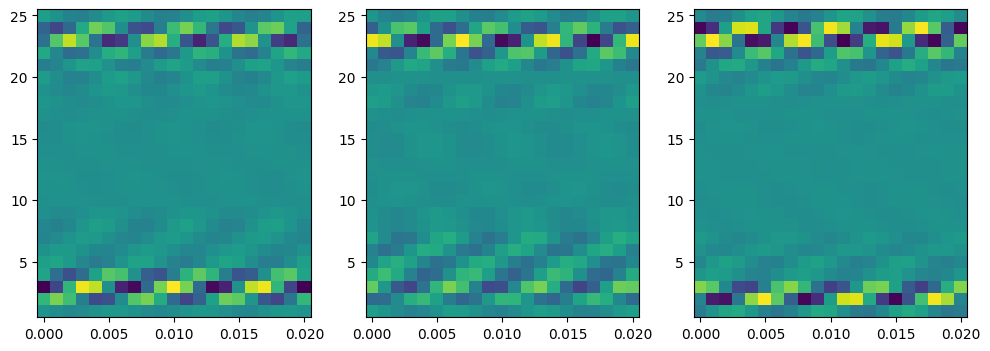

In [2]:
coils = np.arange(1,26)
fig, axes = plt.subplots(1,3,sharex=True, figsize=[12,4])
for i in range(3): 
    axes[i].pcolor(time, coils, db[:, i,:])

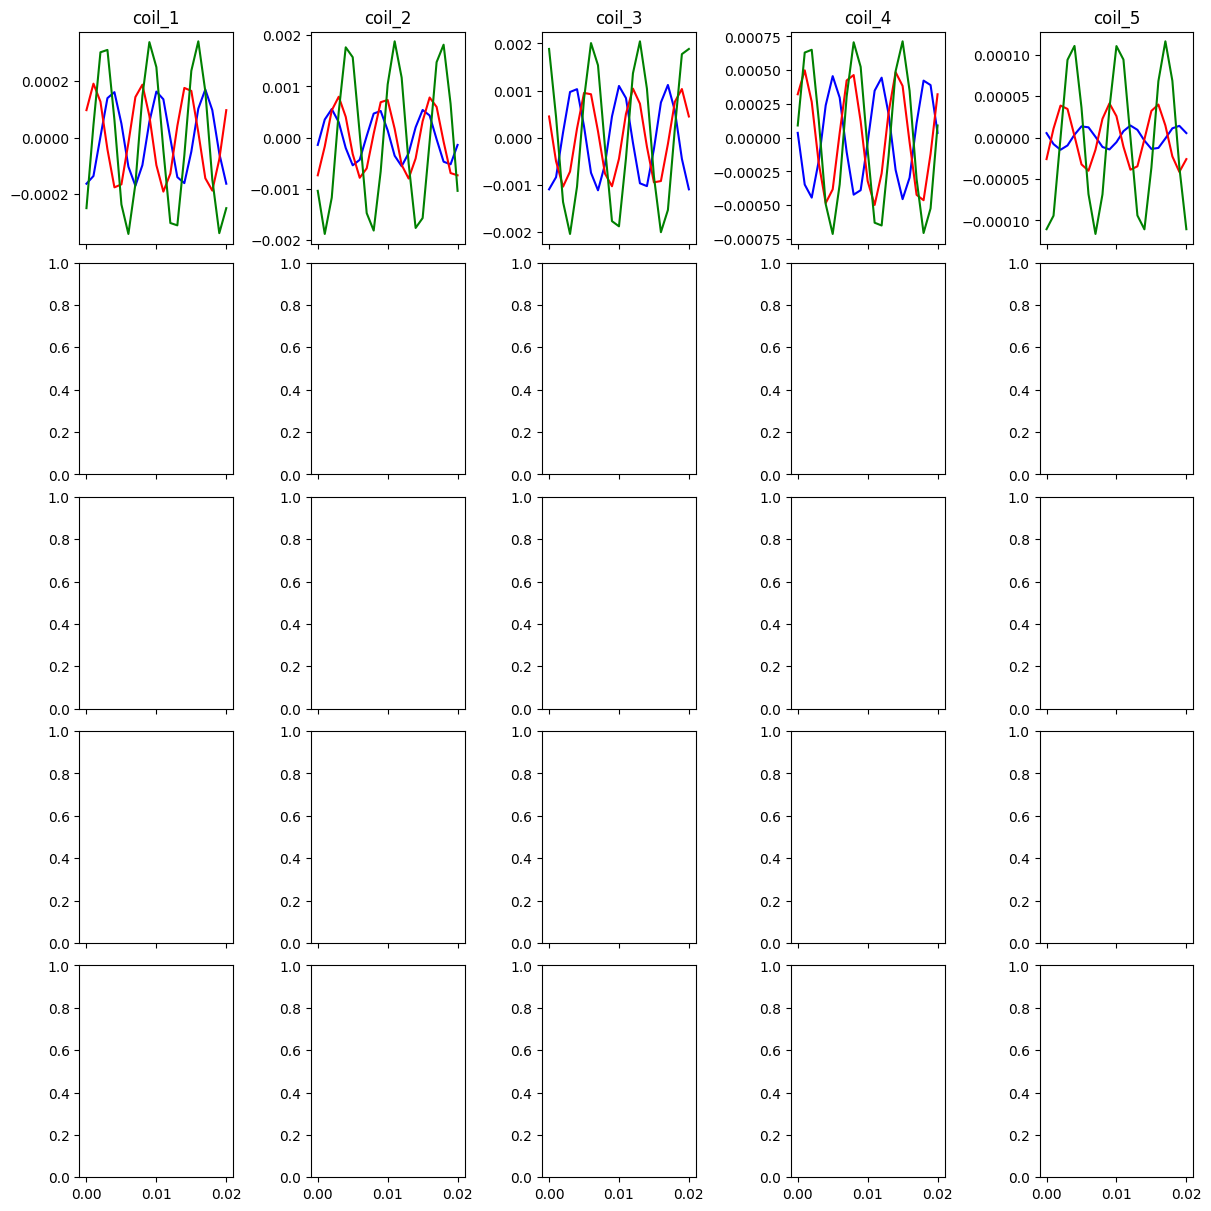

In [2]:
fig_all, axes_all = plt.subplots(
    5, 5, constrained_layout=True, sharex=True, sharey=False, figsize=[12,12]
)
for coil_idx, ax in enumerate(axes_all.flatten()):
    try:
        ax.plot(time, db[coil_idx, 0, :], 'b')
        ax.plot(time, db[coil_idx, 1, :], 'r')
        ax.plot(time, db[coil_idx, 2, :], 'g')
        ax.set(title=f"coil_{coil_idx+1}")
    except:
        pass

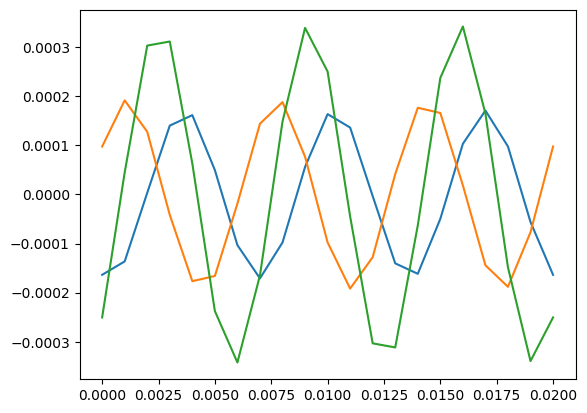

In [3]:
plt.figure()
plt.plot(time, db[0, 0, :])
plt.plot(time, db[0, 1, :])
plt.plot(time, db[0, 2, :])

In [4]:
coil_positions

array([[ 1.0783378,  1.0535891,  1.0238906,  0.9878282,  0.9475231],
       [-1.0783378, -1.0535891, -1.0238906, -0.9878282, -0.9475231],
       [ 0.176    ,  0.226    ,  0.269    ,  0.305    ,  0.333    ]])

/home/pedro/.software/py_science/lib/python3.10/site-packages/matplotlib_inline/backend_inline.py:27: UserWarning: The Figure parameters 'tight_layout' and 'constrained_layout' cannot be used together. Please use 'layout' parameter
  return new_figure_manager_given_figure(num, FigureClass(*args, **kwargs))


(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='n', ylabel='m'>)

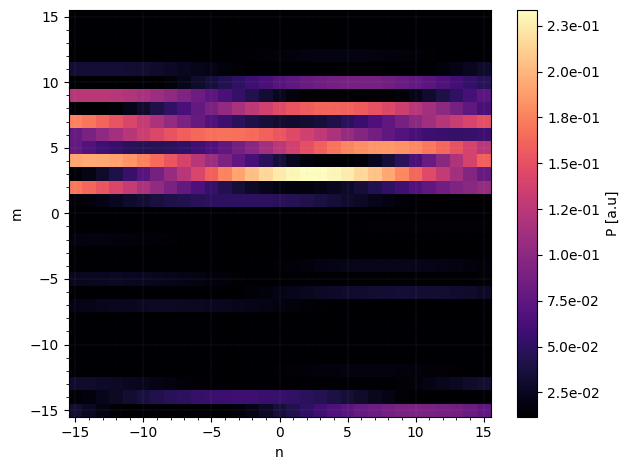

In [3]:
import lomb_periodogram as lp

ms = np.arange(-15,16)
ns = np.arange(-15,16)
th_b, ph_b = np.array([[coil.thetabooz, coil.phibooz] for coil in polarr]).T

mapa = lp.easylomb3(time,  th_b, ph_b, db[:,0,:], 150, ns, ms)

lp.plotmapa_alone(mapa, ns, ms)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import vmec_library as vl
import libreria_calibracion as lc
from synth_mirnov import synthetic_mirnov as sm  # type: ignore
from tictoc import tic, toc

LOAD_BOOZ = True
SAVE_BOOZ = False

def gaussian_profile(s, s0, amp, sigma, phase=0):
    return amp * np.exp(1j * phase) * np.exp(-((s - s0) ** 2) / sigma)


class potential:
    def __init__(self, s, m, n, freq, profile_function=gaussian_profile, **kwargs):
        self.s = s
        self.m = m
        self.n = n
        self.freq = freq
        self.prof = profile_function(s=s, **kwargs)


torarr = lc.Mirnov_T_Array(None)
polarr = lc.Mirnov_P_Array(None)

# coil_positions = [coil.xyz.flatten() for coil in torarr] + [
#     coil.xyz.flatten() for coil in polarr
# ]
coil_positions = [coil.xyz.flatten() for coil in polarr]
coil_positions = np.array(coil_positions).T

import pickle

with open("./booz_pickles/booz_TJII.pkl", "rb") as tfile:
    booz = pickle.load(tfile)

print('BOOZER - LENGTH:', len(booz.th), len(booz.ph))

time = np.linspace(0, 0.02, 21)
potentials = [
    potential(
        booz.s,
        m=5,
        n=8,
        freq=150,
        profile_function=gaussian_profile,
        amp=15,
        phase= np.angle(-1j),
        s0=0.3,
        sigma=0.03,
    ),
    # potential(
    #     booz.s,
    #     m=4,
    #     n=7,
    #     freq=80,
    #     profile_function=gaussian_profile,
    #     amp=5 + 0.1j,
    #     s0=0.4,
    #     sigma=0.03,
    # ),
]

tic()
sm.init_booz(
    s_b=booz.s,
    th_b=booz.th,
    ph_b=booz.ph,
    b_mod_b=booz.vars["mod_b"],
    sqrt_g_b=booz.vars["sqrtg_vecs"],
    phi_b_g=booz.woutdata["phip_b"][-1],
    iota_b=booz.iota,
    x=booz.xyzs["xs"],
    y=booz.xyzs["ys"],
    z=booz.xyzs["zs"],
)

BOOZER - LENGTH: 64 128
 PLANS                    0                    0
 PLANS       94698394144288       94698394645248


True

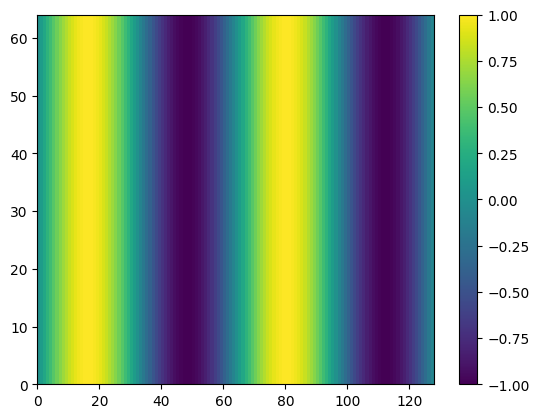

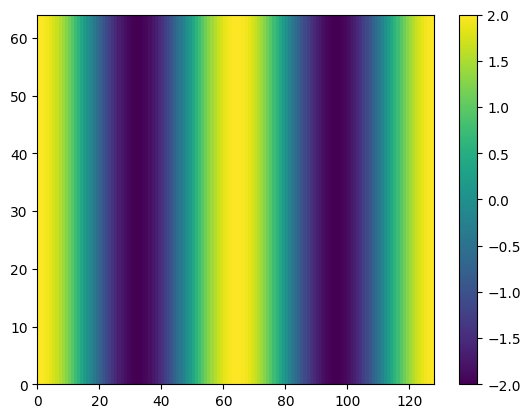

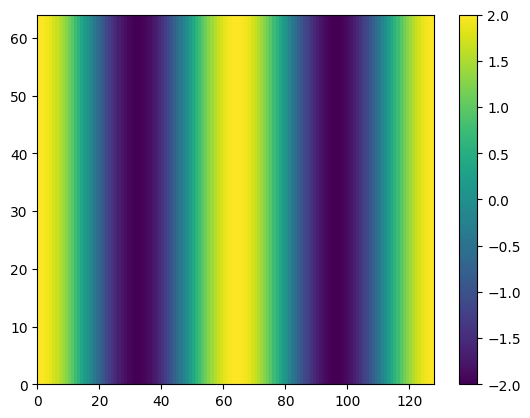

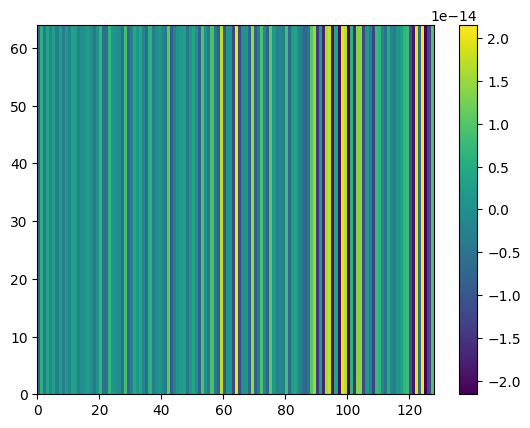

In [2]:
phis, thetas = np.meshgrid(booz.ph, booz.th)
grad_in = np.array([np.sin(2*phis) for i in range(len(booz.s))])
grad_out = np.array([2*np.cos(2*phis) for i in range(len(booz.s))])
out = sm.test_gradient(grad_in)

plt.figure();plt.pcolor(grad_in[0]); plt.colorbar()
plt.figure();plt.pcolor(out[2, 0]); plt.colorbar()
plt.figure();plt.pcolor(grad_out[0]); plt.colorbar()
plt.figure();plt.pcolor(grad_out[0] - out[2, 0]); plt.colorbar()

np.all(np.isclose(grad_out, out[2]))

In [25]:
out[2, 0] / grad_out[0] / np.pi

array([[10.33893661, 10.36354957, 10.38864473, ..., 10.26313039,
        10.28922849, 10.31432365],
       [10.33893661, 10.36354957, 10.38864473, ..., 10.26313039,
        10.28922849, 10.31432365],
       [10.33893661, 10.36354957, 10.38864473, ..., 10.26313039,
        10.28922849, 10.31432365],
       ...,
       [10.33893661, 10.31432365, 10.28922849, ..., 10.41474283,
        10.38864473, 10.36354957],
       [10.33893661, 10.31432365, 10.28922849, ..., 10.41474283,
        10.38864473, 10.36354957],
       [10.33893661, 10.31432365, 10.28922849, ..., 10.41474283,
        10.38864473, 10.36354957]])

In [35]:
thth, phph = np.meshgrid(booz.th, booz.ph)

In [37]:
thth.shape

(128, 64)

In [38]:
booz.th.shape

(64,)

In [39]:
phph.shape

(128, 64)

In [41]:
phph[:,0] == booz.ph

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True]

In [42]:
thth[0]==booz.th

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [3]:

# a = [1,2,3]
# b = [4,5]
a = booz.th
b = booz.ph
aaa, bbb = sm.test_meshgrid(a, b)
aa, bb = np.meshgrid(a, b)

aaa,aa, np.isclose(aaa, aa), bbb, bb, np.isclose(bbb, bb)

(array([[0.        , 0.09817477, 0.19634954, ..., 5.988661  , 6.08683577,
         6.18501054],
        [0.        , 0.09817477, 0.19634954, ..., 5.988661  , 6.08683577,
         6.18501054],
        [0.        , 0.09817477, 0.19634954, ..., 5.988661  , 6.08683577,
         6.18501054],
        ...,
        [0.        , 0.09817477, 0.19634954, ..., 5.988661  , 6.08683577,
         6.18501054],
        [0.        , 0.09817477, 0.19634954, ..., 5.988661  , 6.08683577,
         6.18501054],
        [0.        , 0.09817477, 0.19634954, ..., 5.988661  , 6.08683577,
         6.18501054]]),
 array([[0.        , 0.09817477, 0.19634954, ..., 5.988661  , 6.08683577,
         6.18501054],
        [0.        , 0.09817477, 0.19634954, ..., 5.988661  , 6.08683577,
         6.18501054],
        [0.        , 0.09817477, 0.19634954, ..., 5.988661  , 6.08683577,
         6.18501054],
        ...,
        [0.        , 0.09817477, 0.19634954, ..., 5.988661  , 6.08683577,
         6.18501054],
        [0. 

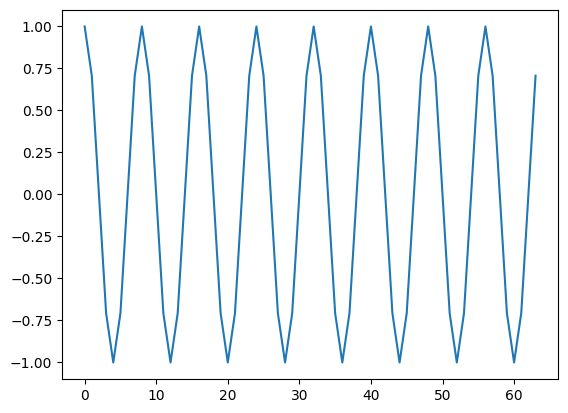

In [7]:
plt.plot(np.exp(1j*8*booz.th))

In [9]:
np.exp(1j*5*booz.ph)

array([ 1.00000000e+00+0.00000000e+00j,  9.70031253e-01+2.42980180e-01j,
        8.81921264e-01+4.71396737e-01j,  7.40951125e-01+6.71558955e-01j,
        5.55570233e-01+8.31469612e-01j,  3.36889853e-01+9.41544065e-01j,
        9.80171403e-02+9.95184727e-01j, -1.46730474e-01+9.89176510e-01j,
       -3.82683432e-01+9.23879533e-01j, -5.95699304e-01+8.03207531e-01j,
       -7.73010453e-01+6.34393284e-01j, -9.03989293e-01+4.27555093e-01j,
       -9.80785280e-01+1.95090322e-01j, -9.98795456e-01-4.90676743e-02j,
       -9.56940336e-01-2.90284677e-01j, -8.57728610e-01-5.14102744e-01j,
       -7.07106781e-01-7.07106781e-01j, -5.14102744e-01-8.57728610e-01j,
       -2.90284677e-01-9.56940336e-01j, -4.90676743e-02-9.98795456e-01j,
        1.95090322e-01-9.80785280e-01j,  4.27555093e-01-9.03989293e-01j,
        6.34393284e-01-7.73010453e-01j,  8.03207531e-01-5.95699304e-01j,
        9.23879533e-01-3.82683432e-01j,  9.89176510e-01-1.46730474e-01j,
        9.95184727e-01+9.80171403e-02j,  9.41544065

array([8.60025416e-01, 9.87046395e-01, 1.12898106e+00, 1.28694075e+00,
       1.46201981e+00, 1.65527733e+00, 1.86771707e+00, 2.10026559e+00,
       2.35374902e+00, 2.62886870e+00, 2.92617602e+00, 3.24604703e+00,
       3.58865720e+00, 3.95395707e+00, 4.34164923e+00, 4.75116731e+00,
       5.18165773e+00, 5.63196477e+00, 6.10061958e+00, 6.58583381e+00,
       7.08549829e+00, 7.59718734e+00, 8.11816889e+00, 8.64542080e+00,
       9.17565336e+00, 9.70533808e+00, 1.02307423e+01, 1.07479697e+01,
       1.12530053e+01, 1.17417662e+01, 1.22101538e+01, 1.26541114e+01,
       1.30696807e+01, 1.34530610e+01, 1.38006662e+01, 1.41091809e+01,
       1.43756125e+01, 1.45973399e+01, 1.47721563e+01, 1.48983055e+01,
       1.49745115e+01, 1.50000000e+01, 1.49745115e+01, 1.48983055e+01,
       1.47721563e+01, 1.45973399e+01, 1.43756125e+01, 1.41091809e+01,
       1.38006662e+01, 1.34530610e+01, 1.30696807e+01, 1.26541114e+01,
       1.22101538e+01, 1.17417662e+01, 1.12530053e+01, 1.07479697e+01,
      

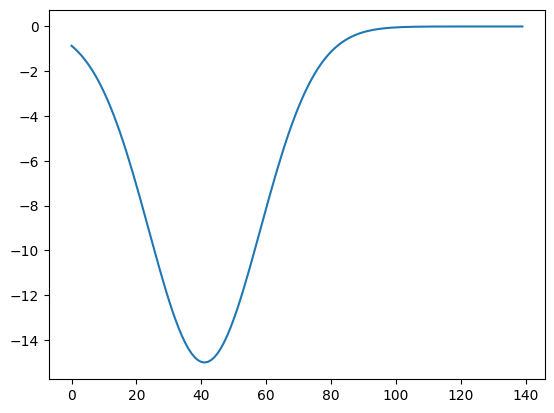

In [17]:
plt.plot(potentials[0].prof.imag)
np.abs(potentials[0].prof)